In [1]:
import os
import sys
import re
import six
import math
import lmdb
import torch

import pandas as pd
from natsort import natsorted
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, ConcatDataset, Subset
from torch._utils import _accumulate
import torchvision.transforms as transforms

class ResizeNormalize(object):

    def __init__(self, size, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        return img



class AlignCollate(object):

    def __init__(self, imgH=32, imgW=100, keep_ratio_with_pad=False):
        self.imgH = imgH
        self.imgW = imgW

    def __call__(self, batch):
        batch = filter(lambda x: x is not None, batch)
        images, labels = zip(*batch)

        transform = ResizeNormalize((self.imgW, self.imgH))
        image_tensors = [transform(image) for image in images]
        image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)

        return image_tensors, labels



In [2]:


class custom_dataset(Dataset):
    def __init__(self,data_csv_file_path):
        df = pd.read_csv(data_csv_file_path,encoding="cp949")
        self.image_path_list = df['path_file'].to_list()
        self.text_label_list = df['label'].to_list()
        self.nSamples = len(self.image_path_list)
    def __len__(self):
        return self.nSamples
    
    def __getitem__(self, index):
        img = Image.open(self.image_path_list[index]).convert('L')
        return (img, self.text_label_list[index])

    
class custom_Batch_Balanced_Dataset(object):
    def __init__(self, opt):
        self.dataloader_iter_list = []
        _AlignCollate = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)
        _dataset = custom_dataset("/data/work_dir/img/generate_text_ko/mrjaehong_text_generation/generate_img/label.csv")
        _data_loader = torch.utils.data.DataLoader(_dataset, batch_size=opt.batch_size,shuffle=True,num_workers=int(opt.workers),collate_fn=_AlignCollate, pin_memory=True)
     
        self.dataloader_iter_list.append(iter(_data_loader))
    def get_batch(self):
        balanced_batch_images = []
        balanced_batch_texts = []

        for i, data_loader_iter in enumerate(self.dataloader_iter_list):
            image, text = data_loader_iter.next()
            balanced_batch_images.append(image)
            balanced_batch_texts += text


        balanced_batch_images = torch.cat(balanced_batch_images, 0)

        return balanced_batch_images, balanced_batch_texts

    
    

In [3]:
import easydict
opt = easydict.EasyDict({
    "exp_name": "test_01",
    "train_data": "/data/data/STARN/data_lmdb_release/training",
    "valid_data":"/data/data/STARN/data_lmdb_release/validation",
    "manualSeed": 1111,
    "workers": 16,
    "batch_size":768,
    "num_iter":300000,
    "valInterval":1,
    "saved_model":'',
    "FT":False,
    "adam":False,
    "lr":1,
    "beta1":0.9,
    "rho":0.95,
    "eps":1e-8,
    "grad_clip":5,
    "baiduCTC":False,
    "select_data":'ST',
    "batch_ratio":'1',
    "total_data_usage_ratio":'1.0',
    "batch_max_length":25,
    "imgW":100,
    "imgH":32,
    "rgb":False,
    "character":"0123456789abcdefghijklmnopqrstuvwxyz",
    "sensitive":False,
    "PAD":False,
    "data_filtering_off":False,
    "Transformation":"TPS",
    "FeatureExtraction":"ResNet",
    "SequenceModeling":"BiLSTM",
    "Prediction":'Attn',
    "num_fiducial":20,
    "input_channel":3,
    "output_channel":512,
    "hidden_size":256    
})

opt.select_data = opt.select_data.split('-')
opt.batch_ratio = opt.batch_ratio.split('-')

train_dataset = custom_Batch_Balanced_Dataset(opt)



In [4]:
image_tensors, labels = train_dataset.get_batch()
print(image_tensors[0].shape)
print(len(labels),labels)

torch.Size([1, 32, 100])
300 ['언제나여기', '이하동문', '별로에요 ', '수고하세요', '불편해함', '오배송됨', '감삿합니다', '걍그래요', '터치안되네', '별로에요 ', '굿 돈늗', '유통기한이', '잘신을게요', '아주조나요', '안사요언거', '조아요 ', '마시쪄요', '방음력 ', '일회용칫솔', '진짜최악임', '짱짱좋아열', '구매실패', '별롱예요', '졸라소냐', '별로네여', '요텈렷샤', '굿굿이에요', '좋아염 굿', '별로였어요', '넘 예버용', '만족합닏3', '가가가가고', '느끼합니다', '넘귀여워요', '효과있어요', '늩흕솢긴', '곽티슈인줄', '빠른배송다', '비추입니다', '안좋아요요', '잘써집니다', '잘쓸게요오', '만족도 2', '짜요짜요짜', '짱짱좋아연', '안찢어져요', '너무 좋요', '만족해용앙', '잘먹네요', '만족 짱', '넘작아요', '디지지짖', '별루에여', '배송불만', '재구매  ', '너무비싸요', '괜히삿움 ', '괜찮아요 ', '그럭저럭요', '힘이 없음', '쥰나닥음 ', '시원시원', '무난합니다', '조 아 오', '넘나좋아요', '불만이예요', '몰라요 ', '불편해요', ' 즈깂깃', '재밋네요', '넘이뻐여', '아재우러대', '잘쓸게오', '너무짭니다', '좋아요 엉', '만에드루여', '앵냐야로', '정말 좋요', '잘쓸께요6', '넘귀여워요', '맛나네요오', '완전별로요', '어머해마아', '굿입니다요', '배송완전', '속상하다', '만독한비다', '완던불사임', '맛없어요', '별로에용', '싸고좋아요', '빠르네요 ', '오졋다리용', '아 비싸', '배송느림요', '11 겟또', '짱이예요', '고장났음 ', '제품질낮음', '재구매 ', '쓸만합니다', '별로예요', '무풍 무풍', '너무 허접', '예버용예용', '빨리왔어야', '맛있어용', '다신안살것', '대만족에요', '감사합니다', '배송기사님', '배송느림', 

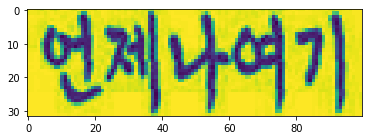

In [5]:
import matplotlib.pyplot as plt

plt.imshow(image_tensors[0].numpy()[0,:,:])
plt.show()

In [6]:
print(image_tensors[1].shape)

torch.Size([1, 32, 100])


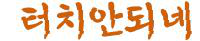

In [7]:
sssxzc = Image.open("/data/work_dir/img/generate_text_ko/mrjaehong_text_generation/generate_img/image/0000000225.jpg")
display(sssxzc)

(200, 41)
<PIL.Image.Image image mode=L size=200x41 at 0x7F1DD9E17990>


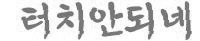

In [8]:
pil_img = Image.open("/data/work_dir/img/generate_text_ko/mrjaehong_text_generation/generate_img/image/0000000225.jpg").convert("L")
print(pil_img.size)  
 
pil_to_tensor = transforms.ToTensor()(pil_img).unsqueeze_(0)

tensor_to_pil = transforms.ToPILImage()(pil_to_tensor.squeeze_(0))
print(tensor_to_pil)
display(tensor_to_pil)